# Exploring difference in $\mathrm{KL}(P \Vert Q)$ vs $\mathrm{KL}(Q \Vert P)$ 


**For the full analysis, refer to the notebook here:** 
> [./Investigating KL Divergence as A Loss Metric](./Investigating%20KL%20Divergence%20as%20a%20loss%20metric.ipynb)

In this notebook, we investigate different divergence loss metrics in a simple optimization problem.

## Key Learning
1. The result depends on the form of $P(x)$. 
    
    P || Q and Q || P looked quite similar qualitatively when the inter-modal separation in the posterior is small. 
    
    ![small_inter-modal_separation](./Comparing%20KL%20P%20Q%20vs%20KL%20Q%20P%20with%20small%20separation.png)
    
    The textbook behavior only arises when this separation is large, in which case the Gaussian end up optimize towards one of the modes in a local minimum.
    
    ![large inter-modal separation](./Comparing%20KL%20P%20Q%20vs%20KL%20Q%20P%20with%20large%20separation.png)
    
2. This result above is makes sense:

    - In the case of $\mathrm{KL}(P \Vert Q)$, the reason why the gaussian tries to spread over the entire $P$ distribution is because the loss will be big anywhere $P(x_i) > 0$ if $Q(x_i)$ is small.

    - Now with $\mathrm{KL}(Q \Vert P)$, the gaussian would try to avoid places where $P(x_i)$ is zero for the same reason. As a result, when the separation between the two modes are large the area in between are close to zero which pushes the Gaussian to one side. On the other hand, if the two modes are close together, the inter-modal area have substantial (non-zero) distribution. As a result, the fitted Gaussian does not experience much "push" to either one side, and the fit with $\mathrm{KL}(P\Vert Q)$ is qualitatively similar to that of $\mathrm{KL}(Q\Vert P)$ in the end.
    
This analysis gave some surprising results at the beginning that turned out quite informative : )
     
### Reference:
- Bishop, *Pattern Recognition and Machine Learning, Chapter 10*.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time

In [5]:
xs = Variable(torch.linspace(-10, 10, 5001))

In [6]:
xs.size()

torch.Size([5001])

In [7]:
ys = Variable(torch.ones(1))

In [8]:
def N(μ, σ2):
    def gaussian(x):
        nonlocal μ, σ2
        z = 2 * np.pi * σ2
        return 1/torch.sqrt(z.expand_as(x)) * torch.exp(-(x - μ.expand_as(x))**2 / z.expand_as(x))
    
    return gaussian

In [56]:
μ = Variable(torch.ones(1)*1, requires_grad=True)
σ2 = Variable(torch.ones(1), requires_grad=True)

In [57]:
Q = N(μ, σ2)

In [58]:
ys = Q(xs)

<IPython.core.display.Javascript object>


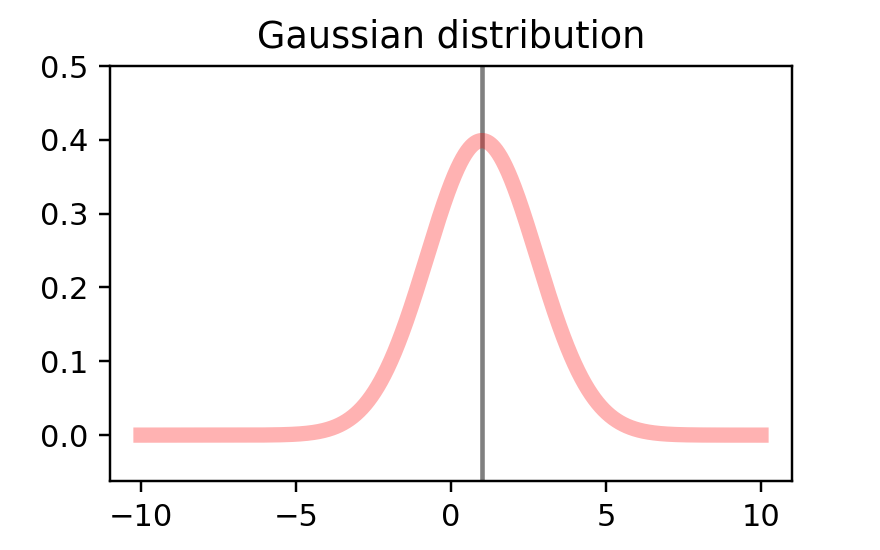

In [70]:
plt.figure(figsize=(4,2.5), dpi=110)
plt.title('Gaussian distribution')
plt.axvline(x=1, color='grey')
plt.ylim(-0.0625, 0.5)
plt.plot(xs.data.numpy(), ys.data.numpy(), linewidth=5, color='red', alpha=0.3);

In [80]:
P = lambda x: 0.75 * N(Variable(torch.ones(1) * -0.125), Variable(torch.ones(1)*0.01))(x) + \
    0.25 * N(Variable(torch.ones(1)), Variable(torch.ones(1)*0.01))(x)

<IPython.core.display.Javascript object>


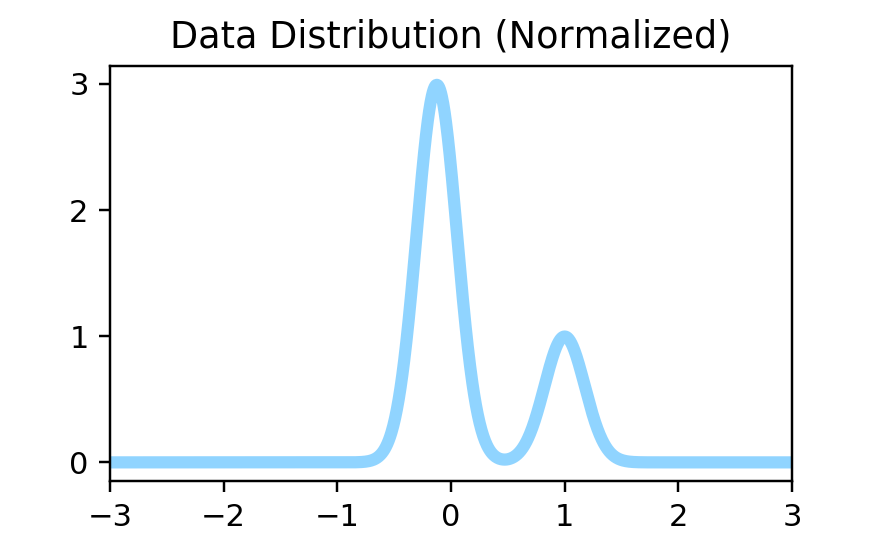

In [82]:
plt.figure(figsize=(4, 2.5), dpi=110)
plt.title('Data Distribution (Normalized)')
plt.plot(xs.data.numpy(), P(xs).data.numpy(), alpha=0.5, color='#23aaff', linewidth=4)
plt.xlim(-3, 3);

In [83]:
ps = P(xs)

In [84]:
qs = Q(xs)

In [85]:
torch.sum(torch.log(ps/qs))

Variable containing:
-inf
[torch.FloatTensor of size 1]

In [86]:
P = lambda x: 0.75 * N(Variable(torch.zeros(1)), Variable(torch.ones(1)*0.01))(x) + \
    0.25 * N(Variable(torch.ones(1)), Variable(torch.ones(1)*0.01))(x)

In [87]:
%matplotlib notebook
time.sleep(3)

<IPython.core.display.Javascript object>


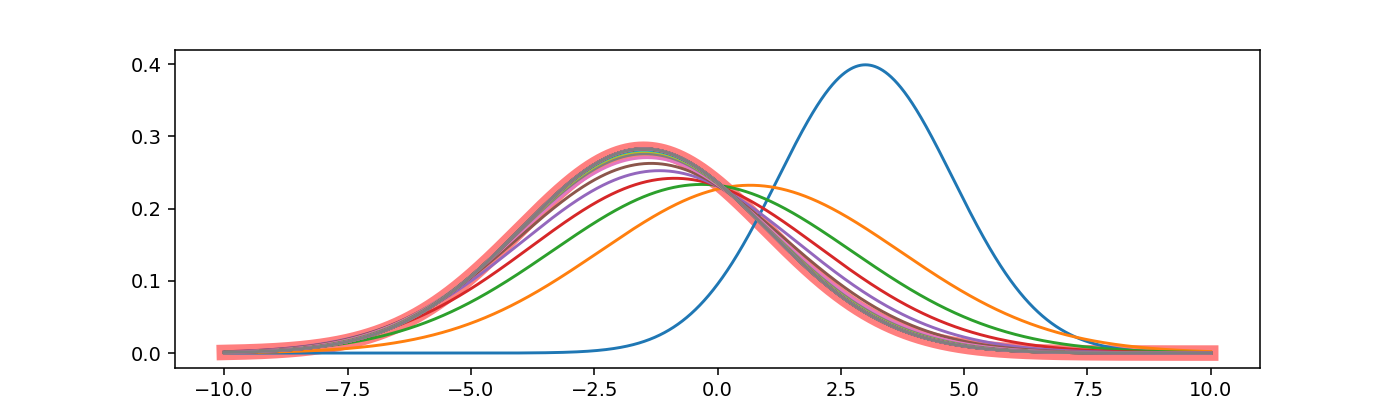

In [88]:
fig = plt.figure(figsize=(10, 3), dpi=70);

In [89]:
μ = Variable(torch.ones(1)*3, requires_grad=True)
σ2 = Variable(torch.ones(1), requires_grad=True)

P = N(Variable(torch.ones(1)*-1.5), Variable(torch.ones(1) * 2))
Q = N(μ, σ2)

α = 1e-12
steps = int(7e2)

plt.plot(xs.data.numpy(), P(xs).data.numpy(), alpha=0.5, color='red', linewidth=8)

optimizer = optim.SGD([μ, σ2], lr=0.0005)
for i in range(steps):
    optimizer.zero_grad()
    ps = P(xs) + α
    qs = Q(xs) + α
    loss = torch.sum(torch.log(ps/qs) * ps)
    loss.backward()
    optimizer.step()
    
    fig.canvas.draw()
    if i % 25 == 0:
        plt.plot(xs.data.numpy(), qs.data.numpy())
        time.sleep(0.1)
    if i % 50 == 0:    
        print(loss.data.numpy()[0], end=', ')

1492.52, 47.9663, 8.10474, 0.979661, 0.0740196, 0.00234613, -0.0021926, -0.00246093, -0.00247422, -0.00248733, -0.0024499, -0.00246822, -0.00246477, -0.00246477, 

<IPython.core.display.Javascript object>


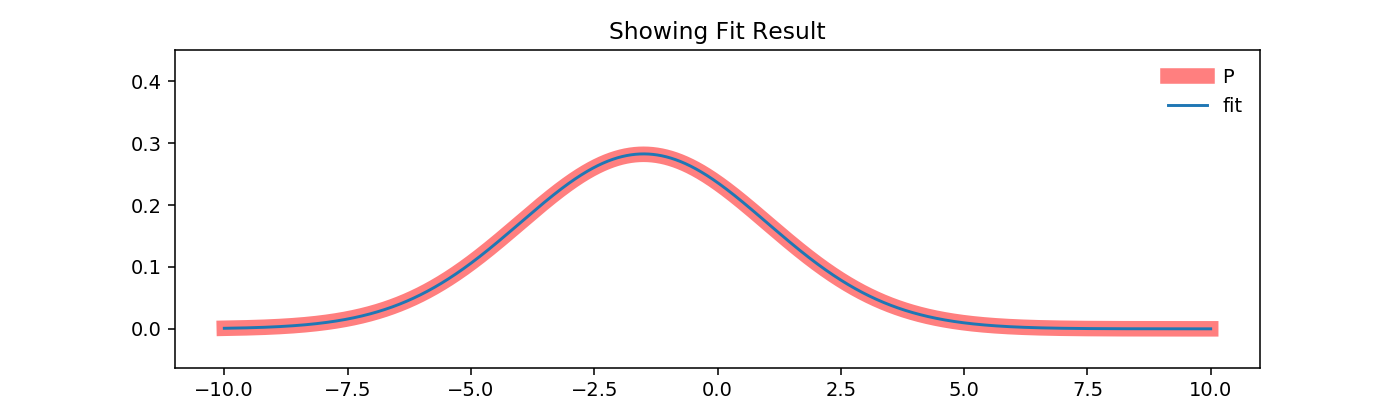

In [93]:
plt.figure(figsize=(10, 3), dpi=70)
plt.title("Showing Fit Result")
plt.plot(xs.data.numpy(), P(xs).data.numpy(), alpha=0.5, color='red', linewidth=8, label='P')
plt.plot(xs.data.numpy(), qs.data.numpy(), label='fit')
plt.ylim(-0.0625, 0.45)
plt.legend(framealpha=1, edgecolor='none')

### Optimize $\mathrm{KL}(P\Vert Q)$

The result shows more mass where $P(x)$ is close to zero.

<IPython.core.display.Javascript object>


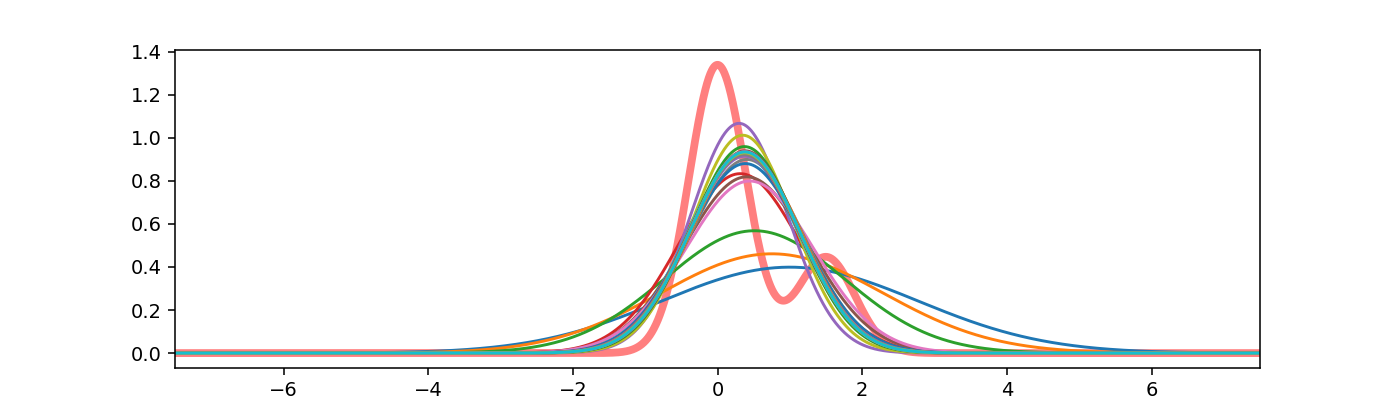

In [171]:
fig = plt.figure(figsize=(10, 3), dpi=70)

In [172]:
μ = Variable(torch.ones(1), requires_grad=True)
σ2 = Variable(torch.ones(1), requires_grad=True)

P = lambda x: 0.75 * N(Variable(torch.zeros(1)), Variable(torch.ones(1)*0.05))(x) + \
    0.25 * N(Variable(1.5 * torch.ones(1)), Variable(torch.ones(1)*0.05))(x)
Q = N(μ, σ2)

α = 1e-12
steps = int(1e2)

plt.plot(xs.data.numpy(), P(xs).data.numpy(), alpha=0.5, color='red', linewidth=4)

optimizer = optim.Adam([μ, σ2], lr=0.05)
for i in range(steps):
    optimizer.zero_grad()
    ps = P(xs) + α
    qs = Q(xs) + α
    loss = torch.sum(torch.log(ps/qs) * ps)
    loss.backward()
    optimizer.step()
    
    fig.canvas.draw()
    if i % 5 == 0:
        plt.plot(xs.data.numpy(), qs.data.numpy())
        plt.xlim(-7.5, 7.5)
        time.sleep(0.1)
    if i % 20 == 0:    
        print(loss.data.numpy()[0], end=', ')

290.177, 80.9117, 72.315, 69.083, 68.657, 

In [173]:
qs_klpq = qs

<IPython.core.display.Javascript object>


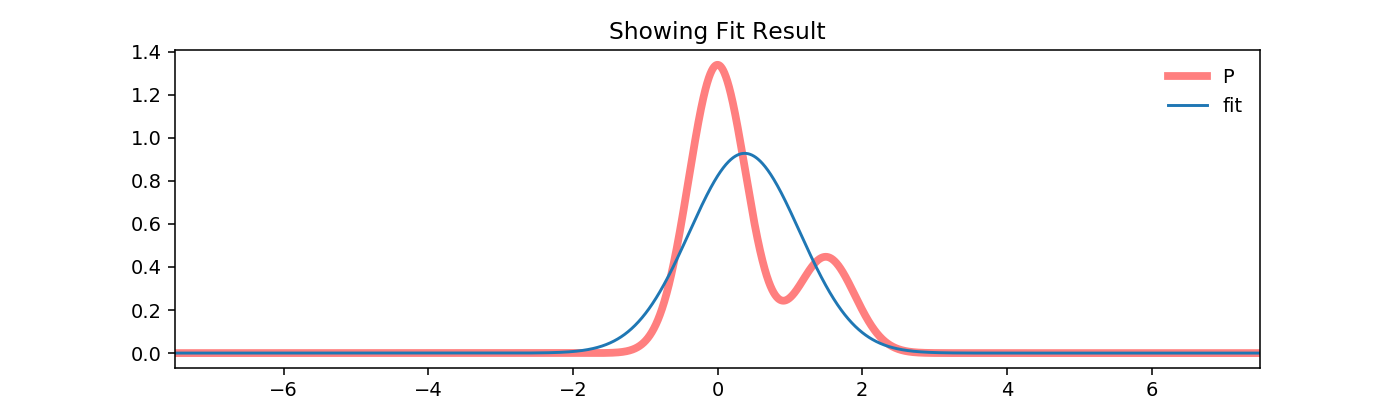

In [174]:
plt.figure(figsize=(10, 3), dpi=70)
plt.title("Showing Fit Result")
plt.plot(xs.data.numpy(), ps.data.numpy(), alpha=0.5, color='red', linewidth=4, label='P')
plt.plot(xs.data.numpy(), qs.data.numpy(), label='fit')
plt.xlim(-7.5, 7.5)
plt.legend(framealpha=1, edgecolor='none');

### Optimize $\mathrm{KL}(Q \Vert P)$

The result shows less mass where $P(x)$ is close to zero.

<IPython.core.display.Javascript object>


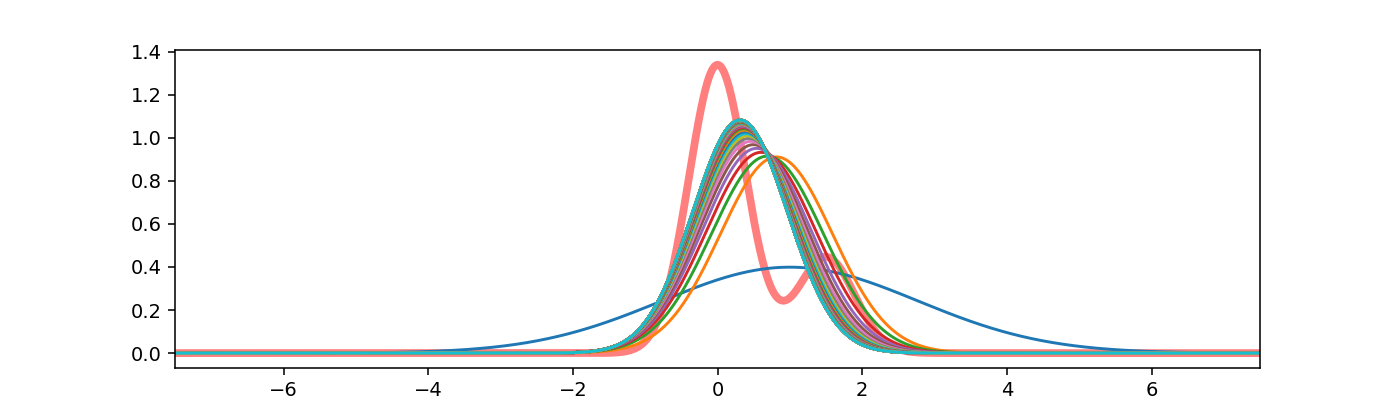

In [195]:
fig = plt.figure(figsize=(10, 3), dpi=70)

In [196]:
μ = Variable(torch.ones(1), requires_grad=True)
σ2 = Variable(torch.ones(1), requires_grad=True)

P = lambda x: 0.75 * N(Variable(-2 * torch.zeros(1)), Variable(torch.ones(1)*0.05))(x) + \
    0.25 * N(Variable(1.5 * torch.ones(1)), Variable(torch.ones(1)*0.05))(x)
Q = N(μ, σ2)

α = 1e-12
steps = int(3e2)

plt.plot(xs.data.numpy(), P(xs).data.numpy(), alpha=0.5, color='red', linewidth=4)

optimizer = optim.SGD([μ, σ2], lr=0.0001)
for i in range(steps):
    optimizer.zero_grad()
    ps = P(xs) + α
    qs = Q(xs) + α
    loss = torch.sum(torch.log(qs/ps) * qs)
    loss.backward()
    optimizer.step()
    
    fig.canvas.draw()
    if i % 5 == 0:
        plt.plot(xs.data.numpy(), qs.data.numpy());
        plt.xlim(-7.5, 7.5)
        time.sleep(0.1)
    if i % 20 == 0:    
        print(loss.data.numpy()[0], end=', ')

1515.76, 96.22, 87.3473, 85.9825, 85.6795, 85.5996, 85.5767, 85.5698, 85.5677, 85.567, 85.5668, 85.5667, 85.5668, 85.5668, 85.5667, 

I'm suspecting that the confidence will be different between the two cases. I'm running out of battery now, will come back to investigate later.

In [177]:
qs_klqp = qs

<IPython.core.display.Javascript object>


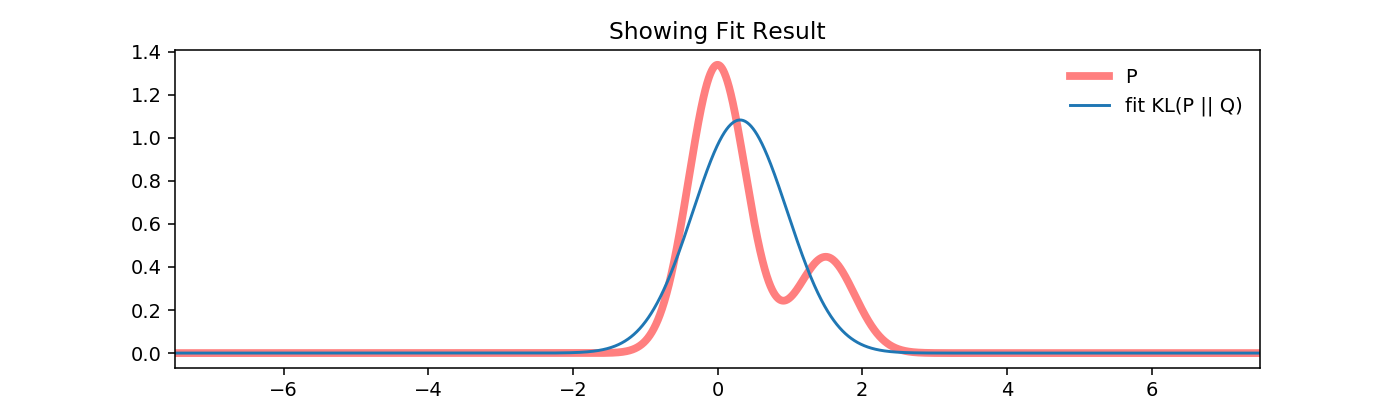

In [197]:
plt.figure(figsize=(10, 3), dpi=70)
plt.title("Showing Fit Result")
plt.plot(xs.data.numpy(), P(xs).data.numpy(), alpha=0.5, color='red', linewidth=4, label='P')
plt.plot(xs.data.numpy(), qs.data.numpy(), label='fit KL(P || Q)')
plt.xlim(-7.5, 7.5)
plt.legend(framealpha=1, edgecolor='none');

It is a bit hard to tell the qualitative difference between these two cases. 
Empirically it looks like the $KL(Q\Vert P)$ loss gives a narrower distribution (smaller variance), but the two
are not **that** qualitatively different (as qualitatively different as the text book example in *Bishop*).

It might be interesting to plot the confidence level of the two models. My macbook is running 
out of juice soon, will continue tomorrow.

<IPython.core.display.Javascript object>


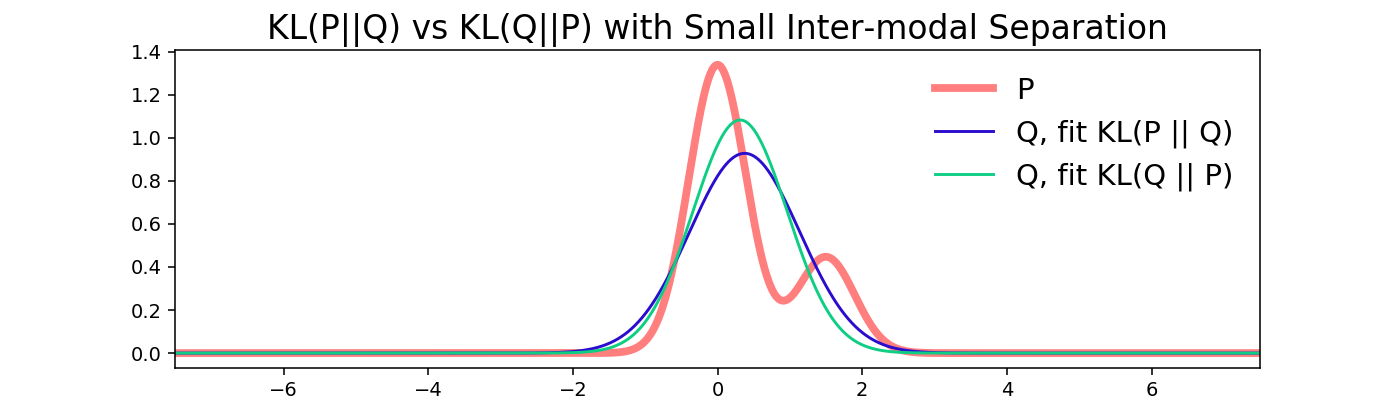

In [198]:
plt.figure(figsize=(10, 3), dpi=70)
plt.title("KL(P||Q) vs KL(Q||P) with Small Inter-modal Separation", fontsize=17)
plt.plot(xs.data.numpy(), P(xs).data.numpy(), alpha=0.5, color='red', linewidth=4, label='P')
plt.plot(xs.data.numpy(), qs_klpq.data.numpy(), label='Q, fit KL(P || Q)', color='#2a0dce')
plt.plot(xs.data.numpy(), qs_klqp.data.numpy(), label='Q, fit KL(Q || P)', color='#0ece84')
plt.xlim(-7.5, 7.5)
plt.legend(framealpha=1, edgecolor='none', fontsize=15)
plt.savefig('Comparing KL P Q vs KL Q P with small separation.png')

A reading through Bishop's text book expects a different result for $\mathrm{KL}(Q\Vert P)$.

<img alt="Bishop 10.1 KL PQ vs QP" src="./Bishop%2010-1%20KL%20divergence%20PQ%20vs%20QP.png" width="400px"></img>

A closer look of the example in Bishop's book made me think that a large separation between the modes in the posterior is needed in order for the $\mathrm{KL}(Q\Vert P)$ optimized result to look like the figure. Specifically, the inter-modal area need to be close to zero.

A quick experiment confirmed this intuition below:

In this example, the separation between the two modes are bigger.

<IPython.core.display.Javascript object>


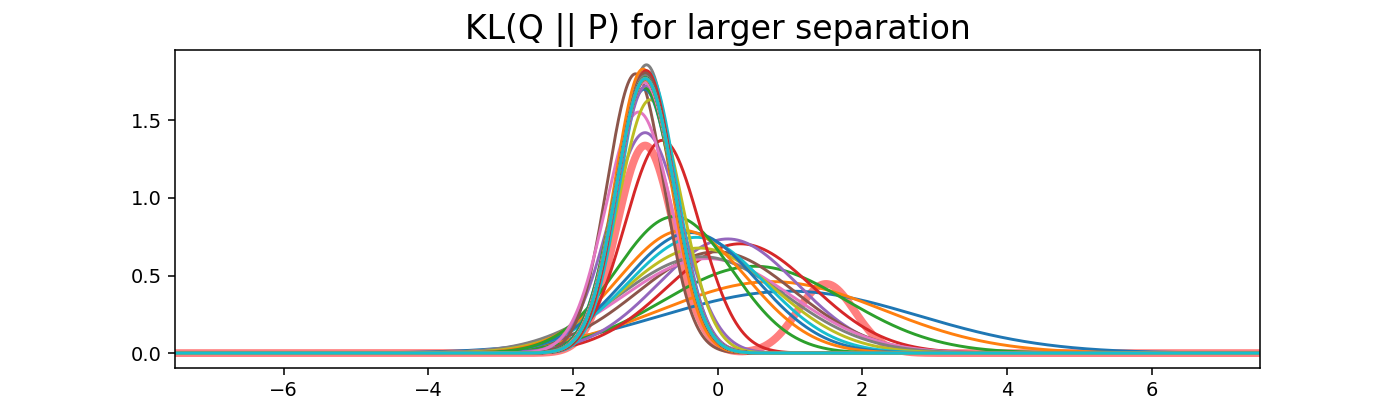

In [199]:
fig = plt.figure(figsize=(10, 3), dpi=70)
plt.title('KL(Q || P) for larger separation', fontsize=17);

In [200]:
μ = Variable(torch.ones(1), requires_grad=True)
σ2 = Variable(torch.ones(1), requires_grad=True)

P = lambda x: 0.75 * N(Variable(torch.ones(1) * -1), Variable(torch.ones(1)*0.05))(x) + \
    0.25 * N(Variable(1.5 * torch.ones(1)), Variable(torch.ones(1)*0.05))(x)
Q = N(μ, σ2)

α = 1e-12
steps = int(3e2)

plt.plot(xs.data.numpy(), P(xs).data.numpy(), alpha=0.5, color='red', linewidth=4)

optimizer = optim.Adam([μ, σ2], lr=0.05)
for i in range(steps):
    optimizer.zero_grad()
    ps = P(xs) + α
    qs = Q(xs) + α
    loss = torch.sum(torch.log(qs/ps) * qs)
    loss.backward()
    optimizer.step()
    
    fig.canvas.draw()
    if i % 5 == 0:
        plt.plot(xs.data.numpy(), qs.data.numpy());
        plt.xlim(-7.5, 7.5)
        time.sleep(0.1)
    if i % 20 == 0:    
        print(loss.data.numpy()[0], end=', ')

1354.67, 511.612, 435.351, 361.091, 147.313, 127.819, 127.443, 126.896, 126.89, 126.884, 126.883, 126.883, 126.883, 126.883, 126.883, 

In [192]:
qs_klqp_ls = qs

<IPython.core.display.Javascript object>


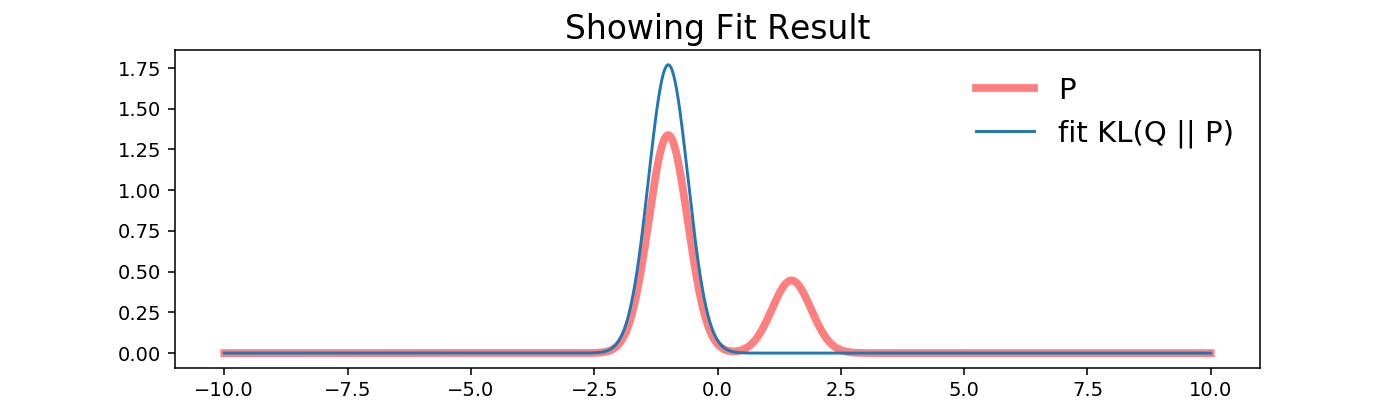

In [193]:
plt.figure(figsize=(10, 3), dpi=70)
plt.title("Showing Fit Result", fontsize=17)
plt.plot(xs.data.numpy(), P(xs).data.numpy(), alpha=0.5, color='red', linewidth=4, label='P')
plt.plot(xs.data.numpy(), qs.data.numpy(), label='fit KL(Q || P)')
plt.legend(framealpha=1, edgecolor='none', fontsize=15);

Now let's compare the two fits in this case!

<IPython.core.display.Javascript object>


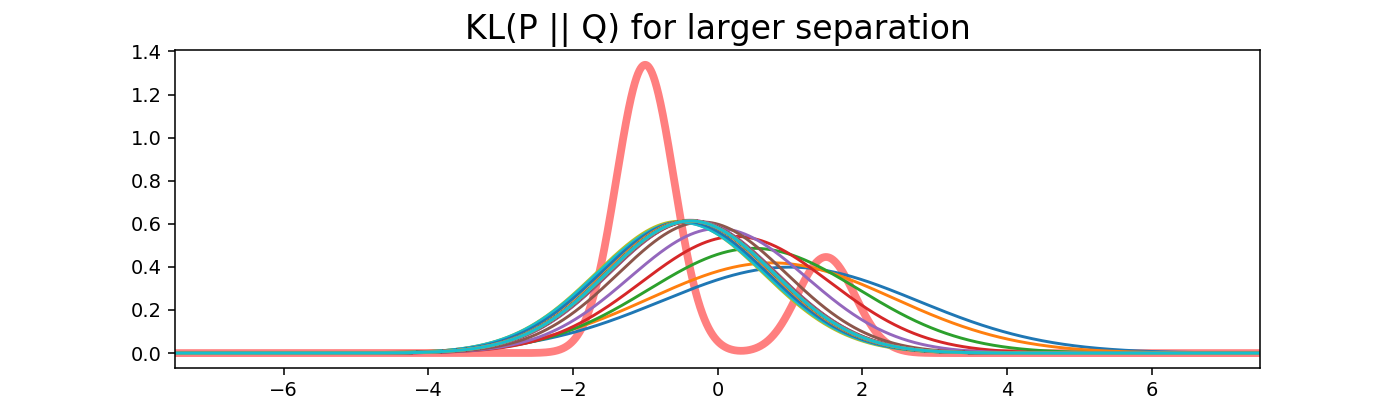

In [202]:
fig = plt.figure(figsize=(10, 3), dpi=70)
plt.title('KL(P || Q) for larger separation', fontsize=17);

In [203]:
μ = Variable(torch.ones(1), requires_grad=True)
σ2 = Variable(torch.ones(1), requires_grad=True)

P = lambda x: 0.75 * N(Variable(torch.ones(1) * -1), Variable(torch.ones(1)*0.05))(x) + \
    0.25 * N(Variable(1.5 * torch.ones(1)), Variable(torch.ones(1)*0.05))(x)
Q = N(μ, σ2)

α = 1e-12
steps = int(3e2)

plt.plot(xs.data.numpy(), P(xs).data.numpy(), alpha=0.5, color='red', linewidth=4)

optimizer = optim.Adam([μ, σ2], lr=0.05)
for i in range(steps):
    optimizer.zero_grad()
    ps = P(xs) + α
    qs = Q(xs) + α
    loss = torch.sum(torch.log(ps/qs) * ps)
    loss.backward()
    optimizer.step()
    
    fig.canvas.draw()
    if i % 5 == 0:
        plt.plot(xs.data.numpy(), qs.data.numpy());
        plt.xlim(-7.5, 7.5)
        time.sleep(0.1)
    if i % 20 == 0:    
        print(loss.data.numpy()[0], end=', ')

420.924, 248.143, 228.541, 224.842, 224.824, 224.817, 224.812, 224.811, 224.811, 224.811, 224.811, 224.811, 224.811, 224.811, 224.811, 

In [167]:
qs_klpq_ls = qs

<IPython.core.display.Javascript object>


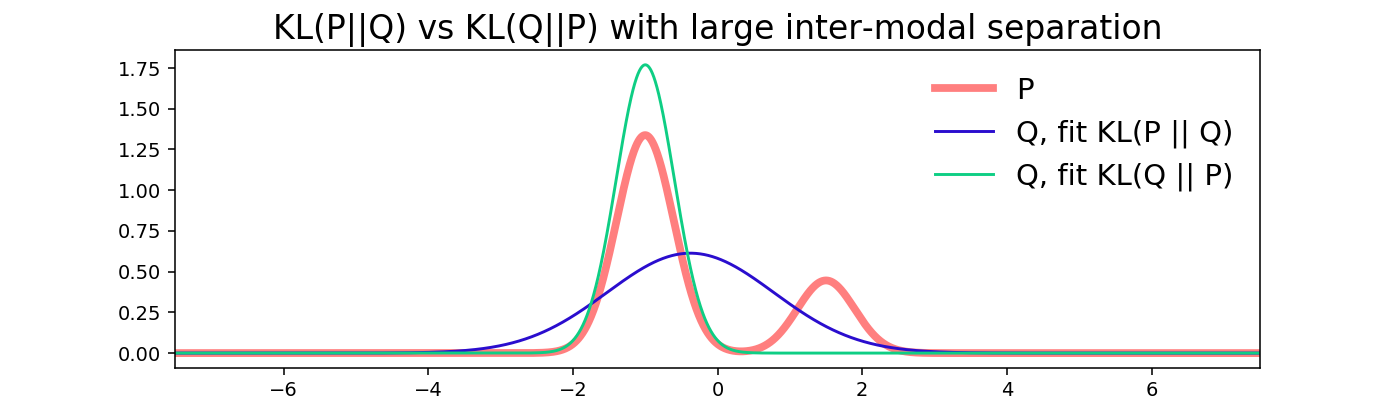

In [201]:
plt.figure(figsize=(10, 3), dpi=70)
plt.title("KL(P||Q) vs KL(Q||P) with large inter-modal separation", fontsize=17)
plt.plot(xs.data.numpy(), P(xs).data.numpy(), alpha=0.5, color='red', linewidth=4, label='P')
plt.plot(xs.data.numpy(), qs_klpq_ls.data.numpy(), label='Q, fit KL(P || Q)', color='#2a0dce')
plt.plot(xs.data.numpy(), qs_klqp_ls.data.numpy(), label='Q, fit KL(Q || P)', color='#0ece84')
plt.xlim(-7.5, 7.5)
plt.legend(framealpha=1, edgecolor='none', fontsize=15)
plt.savefig('Comparing KL P Q vs KL Q P with large separation.png')